RAINSTORM

## Seize labels

- This notebook will help us visualize the results from labeled videos of an experiment

#### Requirements:

- The position files (processed by [2a-Prepare_positions](2a-Prepare_positions.ipynb))
- The movement files (processed by [2b-Geometric_analysis](2b-Geometric_analysis.ipynb))
- The labels, geolabels or autolabels files (labeled by [1-Behavioral_labeler](1-Behavioral_labeler.ipynb), [2b-Geometric_analysis](2b-Geometric_analysis.ipynb) or [3b-Automatic_analysis](3b-Automatic_analysis.ipynb))

---
#### Load the necessary modules

In [1]:
from pathlib import Path
import rainstorm.seize_labels as rst

---
#### 1. State your project path and experiment details in the params file
Define the path to the experiment folder, and the path to the parameters file.

Go to the params.yaml file and specify the parameters in the *seize_labels* section.

In [2]:
base = Path.cwd()
folder_path = base / r'examples\NOR'
params_file = folder_path / 'params.yaml'

---
#### 2. Visualize the behavioral labels on a video

The following function combines the position data, the behavioral labels, and the original video recording to create a video with the labels overlaid.

The video can be built both using the original video file or not... try removing the `video_path` argument from the function call to see the difference.

In [3]:
example_path = rst.choose_example_positions(params_file, look_for = 'TS')

Found 10 file(s) matching 'TS'. Using: 'NOR_TS_06_positions.csv'


In [4]:
video_name = example_path.name.replace('_positions.csv', '.mp4')
video_path = folder_path / 'TS_videos' / video_name
# rst.create_video(params_file, example_path, video_path)

---
#### 3. Plot individual exploration


Exploration is a dynamic behavior, and experiment results can change a lot depending on the timeframe chosen for analysis. A first step to understanding the exploration dynamics is to plot the evolution of the cumulative exploration time.

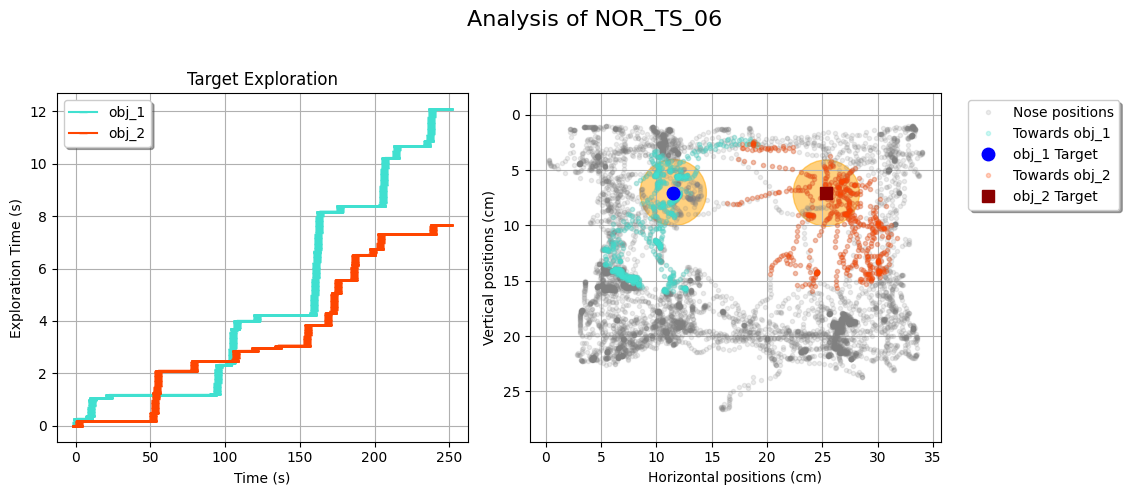

In [5]:
rst.plot_mouse_exploration(params_file, example_path)

This plot shows the behavior of a single subject, and does not take into account the role of each exploratory target. To build more elaborate plots, we need to inform the groups and target roles for each mice and trial.

---
#### 4. Create a ‘reference.csv’ file on our experiment folder.
This function will use the groups, trials and target roles we state on the params file to create a ‘reference.csv’ file that will be used to organize the files and plot the experiment results.

In [6]:
reference_path = rst.create_reference_file(params_file)

Reference file already exists at c:\Users\dhers\Desktop\RAINSTORM\examples\NOR\reference.csv. Use overwrite=True to recreate it.


#### Go to the experiment folder and complete the 'reference.csv' file
If you are using the NOR example folder to try out rainstorm, you will find a copy of the ‘reference.csv’ file **already completed** in the experiment folder.

With the ‘reference.csv’ file complete, you can proceed to the next step where it will be used to create the 'summary' folder.

---
#### 5. Create the 'Summary' folder
This new folder will contain files for each video recording, which will be used to hold all the labels and geometric information.

The groups and objects on the ‘reference.csv’ file will be used to organize the files into subfolders, and the target columns will be renamed according to their role (e.g. Novel and Known).

In [7]:
summary_path = rst.create_summary_files(params_file)

Summary file already exists at c:\Users\dhers\Desktop\RAINSTORM\examples\NOR\summary\24_hs\Hab\NOR_Hab_01_summary.csv. Use overwrite=True to recreate it.
Summary file already exists at c:\Users\dhers\Desktop\RAINSTORM\examples\NOR\summary\24_hs\Hab\NOR_Hab_02_summary.csv. Use overwrite=True to recreate it.
Summary file already exists at c:\Users\dhers\Desktop\RAINSTORM\examples\NOR\summary\1_week\Hab\NOR_Hab_03_summary.csv. Use overwrite=True to recreate it.
Summary file already exists at c:\Users\dhers\Desktop\RAINSTORM\examples\NOR\summary\1_week\Hab\NOR_Hab_04_summary.csv. Use overwrite=True to recreate it.
Summary file already exists at c:\Users\dhers\Desktop\RAINSTORM\examples\NOR\summary\24_hs\Hab\NOR_Hab_05_summary.csv. Use overwrite=True to recreate it.
Summary file already exists at c:\Users\dhers\Desktop\RAINSTORM\examples\NOR\summary\24_hs\Hab\NOR_Hab_06_summary.csv. Use overwrite=True to recreate it.
Summary file already exists at c:\Users\dhers\Desktop\RAINSTORM\examples\N

---
#### 6. With our files ready, all is left to do is to run the analysis and plot the results.

We can plot...

For all trials:
- lineplot_cumulative_distance
- lineplot_cumulative_freezing_time

For trials with targets:
- lineplot_cumulative_exploration_time
- boxplot_total_exploration_time

Some calculated index:
- lineplot_DI
- lineplot_diff
- boxplot_DI_auc (Area under the curve of the lineplot_DI)
- boxplot_avg_time_bias (An "average rate of bias" obtained by dividing the diff AUC by the total session duration)

And finally, some ROIs realted plots:
- boxplot_roi_time
- boxplot_roi_distance
- boxplot_alternation_proportion

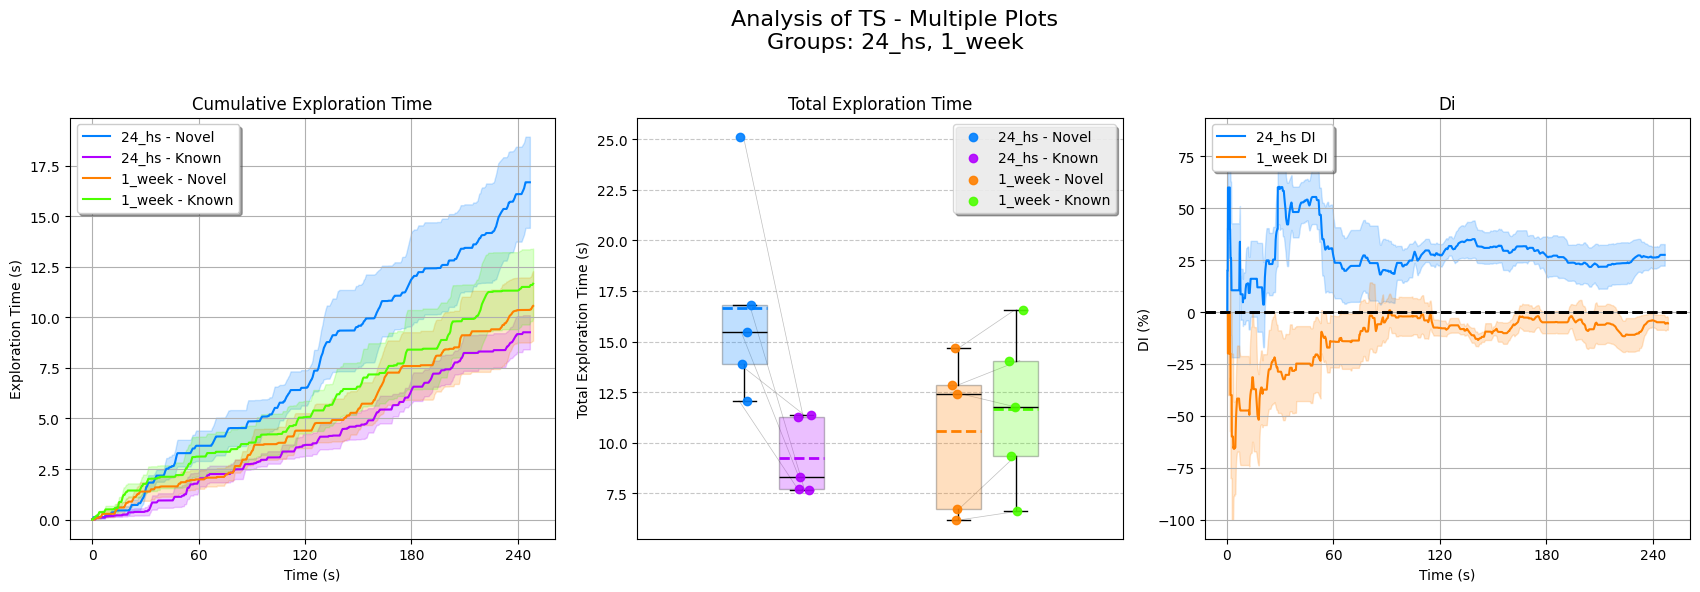

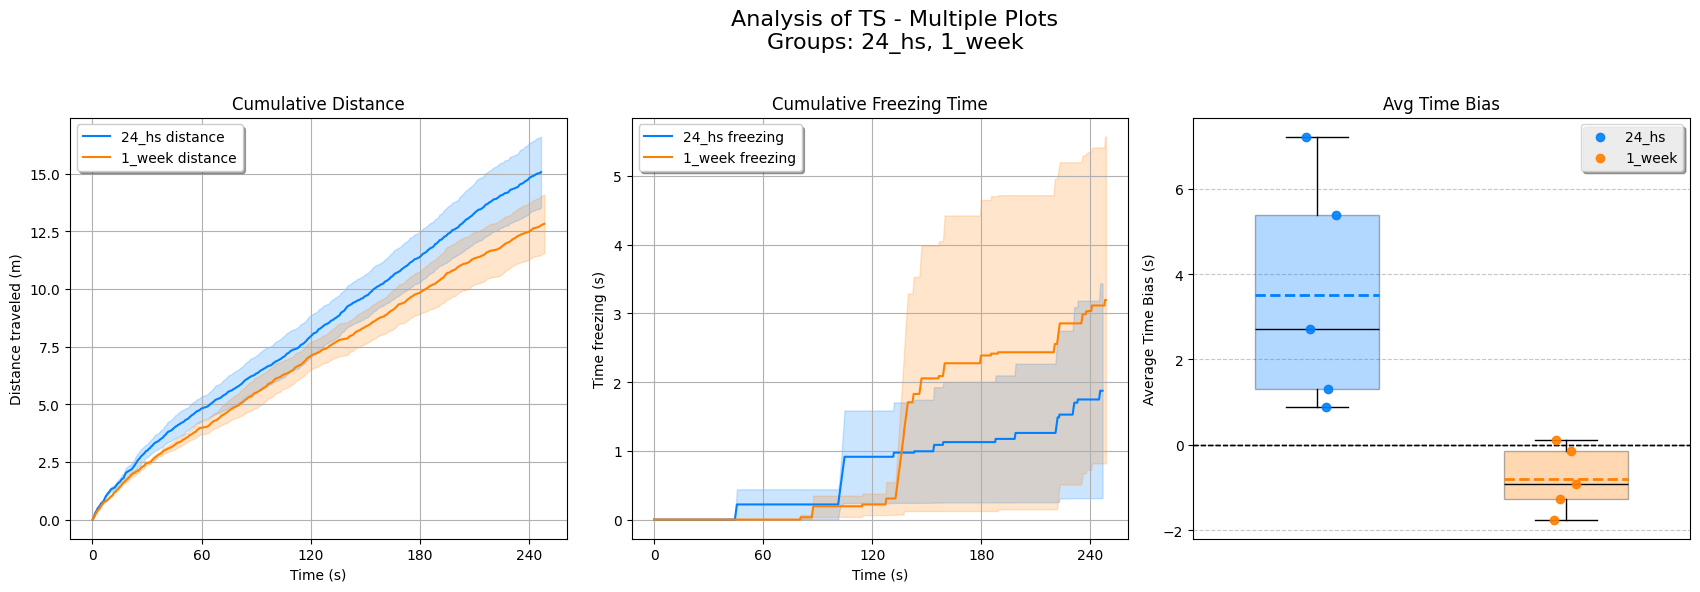

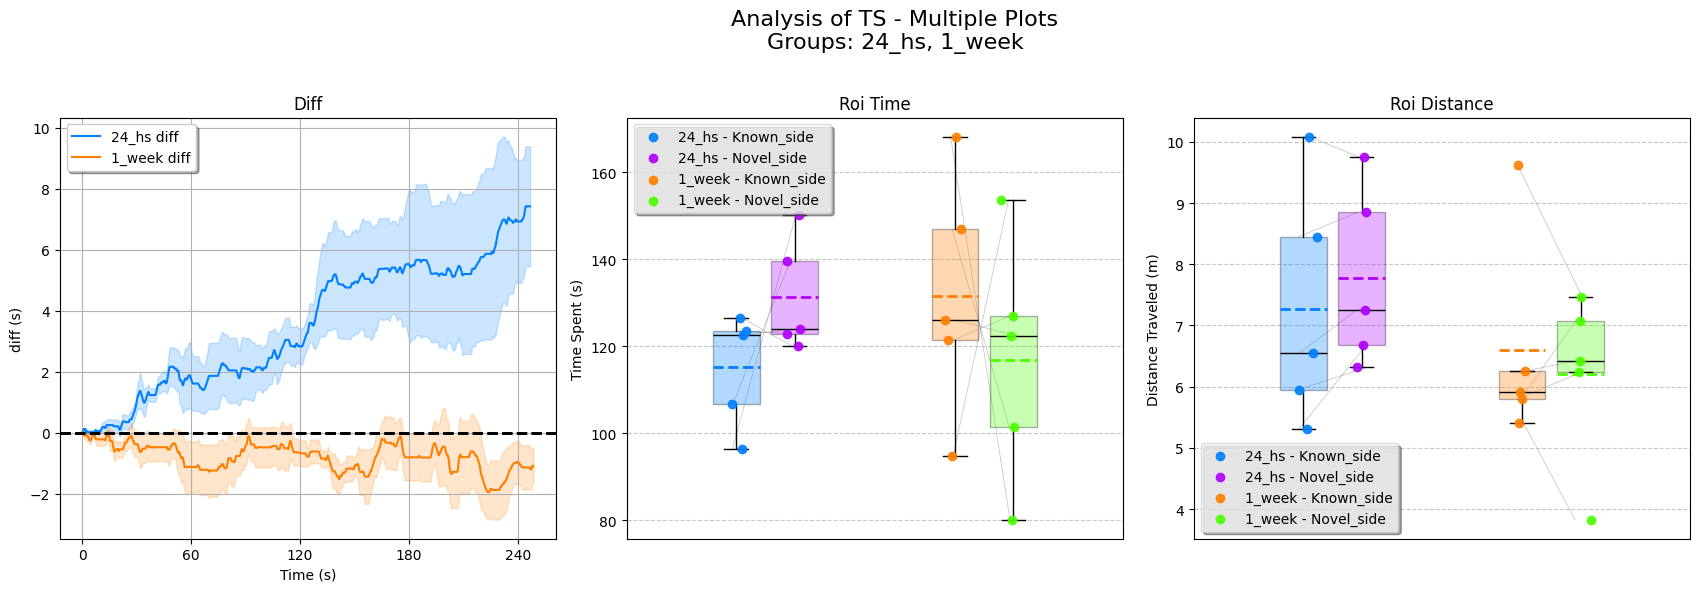

In [8]:
rst.plot_multiple_analyses(params_file, trial='TS', plots=[rst.lineplot_cumulative_exploration_time, rst.boxplot_total_exploration_time, rst.lineplot_DI])
rst.plot_multiple_analyses(params_file, trial='TS', plots=[rst.lineplot_cumulative_distance, rst.lineplot_cumulative_freezing_time, rst.boxplot_avg_time_bias])
rst.plot_multiple_analyses(params_file, trial='TS', plots=[rst.lineplot_diff, rst.boxplot_roi_time, rst.boxplot_roi_distance])

#### These modular graphs are intended to show the dynamic behavior of mice, providing a deeper insight into what happens during learning and memory.


---
#### 7. Make a csv file with the results of the experiment

The results.csv file will be stored in the experiment folder, and will contain columns for each of the variables plotted above. It is meant to be used for further statistical analysis.

In [9]:
rst.create_results_file(params_file)

Results file saved at c:\Users\dhers\Desktop\RAINSTORM\examples\NOR\results.csv


WindowsPath('c:/Users/dhers/Desktop/RAINSTORM/examples/NOR/results.csv')

---
#### 8. Bonus track... For each mouse, create individual plots

This function is thought particularly for experiments like Novel Object Recognition, since it only works properly if we have two targets on the arena.
The individual plots give us the chance to evaluate if something is off, and spot any behavioral outliers on both training and testing sessions.

You can test it with the demo data without problems, the plots will be stored in the example folder.

In [10]:
rst.plot_all_individual_analyses(params_file)


We have reached the end of this project. If you have read and followed the code up to this point, I want to thank you for your time and attention.

If you have any questions and/or suggestions, do not hesitate to write: sdhers@fbmc.fcen.uba.ar


---
RAINSTORM - Created on Jun 25, 2024 - @author: Santiago D'hers